Bitcoin_Price_Prediction 

In [38]:
# Cell 1: Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pickle
from sklearn.metrics import mean_squared_error

file_path = 'BTC-USD-v2.csv'
# Function Definitions
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    return df.dropna()

def normalize_data(df):
    data = df.filter(['Close'])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def split_data(scaled_data, train_size=0.7, val_size=0.15):
    train_len = int(len(scaled_data) * train_size)
    val_len = int(len(scaled_data) * val_size)
    train_data = scaled_data[:train_len]
    val_data = scaled_data[train_len:train_len + val_len]
    test_data = scaled_data[train_len + val_len:]
    return train_data, val_data, test_data

def prepare_data(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    return rmse, mse



In [39]:
# Cell 2: Load and Clean Data
df = load_and_clean_data(file_path)


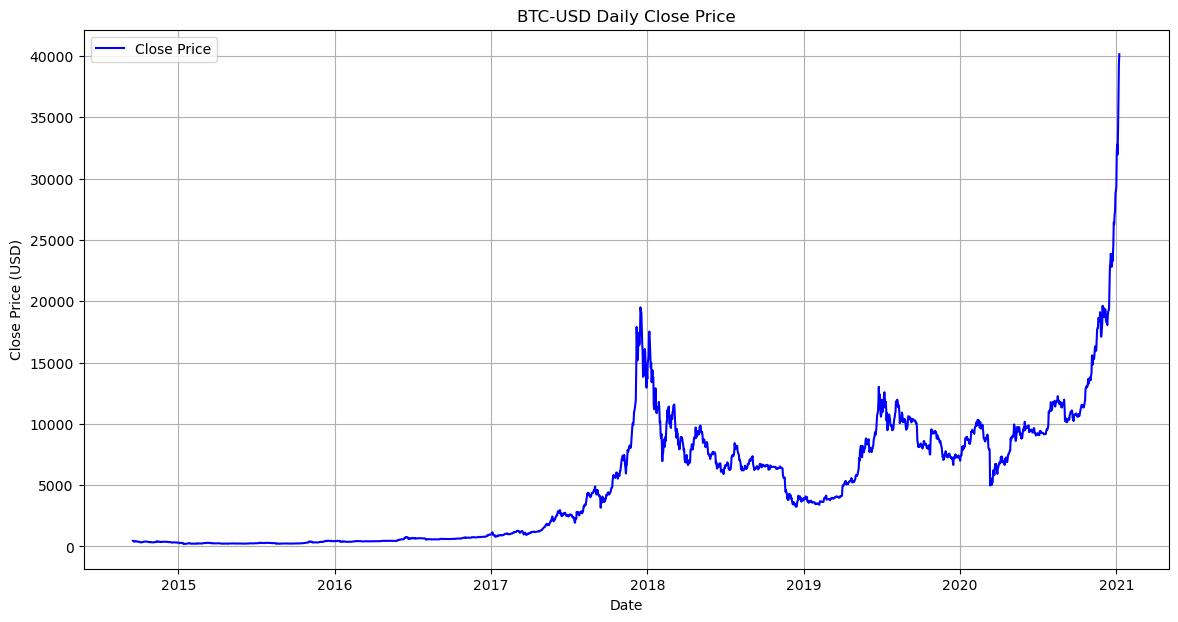

In [40]:
# Cell 3: Plotting the Closing Price
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('BTC-USD Daily Close Price')
plt.legend()
plt.grid(True)
plt.show()


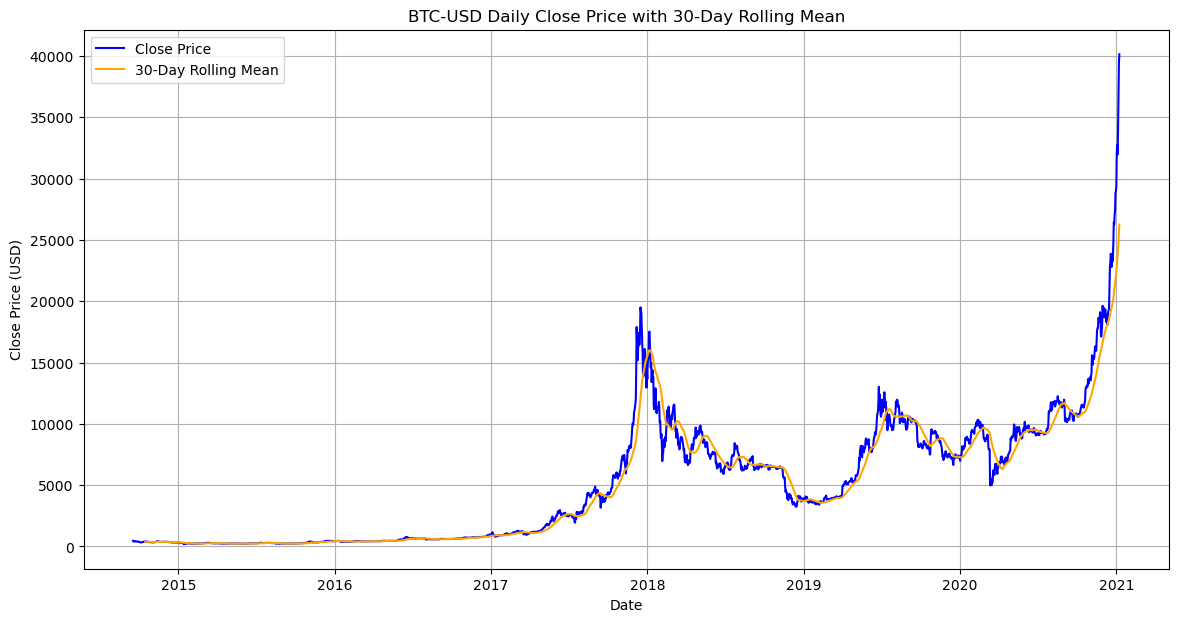

In [41]:
# Cell 4: Plotting Rolling Mean
df['Rolling Mean'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['Rolling Mean'], label='30-Day Rolling Mean', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('BTC-USD Daily Close Price with 30-Day Rolling Mean')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# Cell 5: Normalize the Data
scaled_data, scaler = normalize_data(df)


In [43]:
# Cell 6: Split the Data
train_data, val_data, test_data = split_data(scaled_data)


In [44]:
# Cell 7: Prepare the Data for LSTM
x_train, y_train = prepare_data(train_data)
x_val, y_val = prepare_data(val_data)


In [46]:
# Cell 8: Define and Train the LSTM Model
from tensorflow.keras import Input

model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=60, return_sequences=True))
model.add(LSTM(units=60, return_sequences=True))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val), verbose=1)


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 6.4819e-04 - val_loss: 5.4144e-04
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.4495e-04 - val_loss: 6.2588e-04
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.7066e-04 - val_loss: 6.9594e-04
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 2.7679e-04 - val_loss: 4.9577e-04
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2234e-04 - val_loss: 4.2217e-04
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.5339e-04 - val_loss: 3.8732e-04
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 4.0171e-04 - val_loss: 7.0909e-04
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.3975e-04 - val_loss: 3.4616e-04
Epoch 10/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 2.3934e-04 - val_loss: 3.1019e-04
Epoch 11/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.8645e-04 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


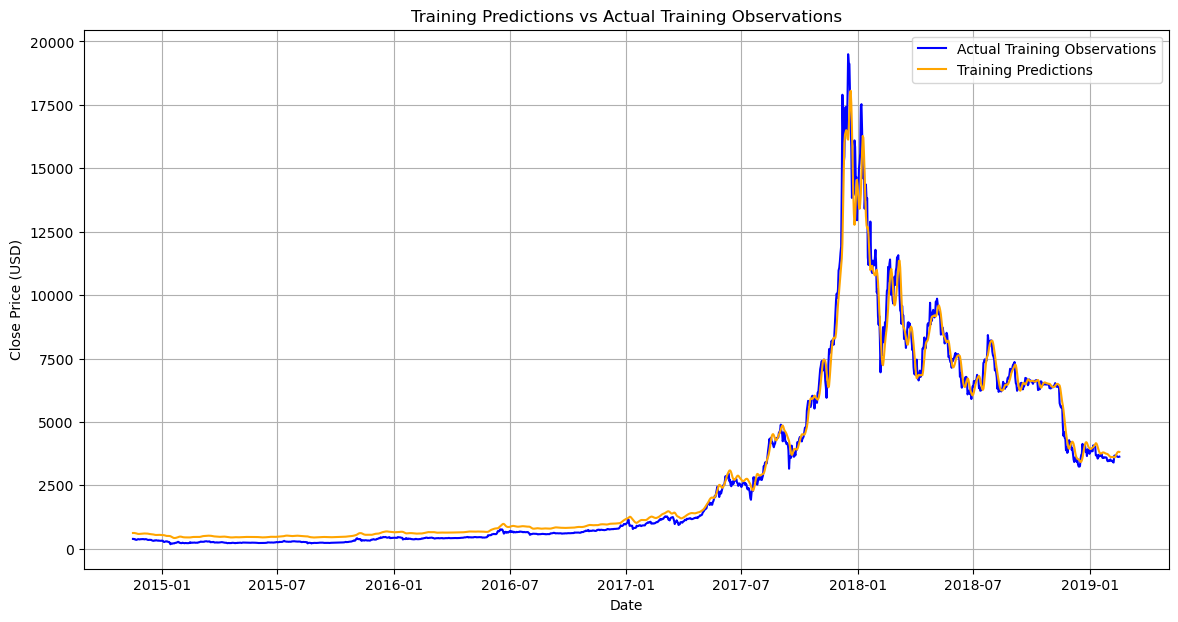

In [47]:
# Cell 9: Prepare Test Data and Make Predictions
x_test, y_test_actual = prepare_data(test_data)

# Make predictions on test data
test_predictions = model.predict(x_test)

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(model.predict(x_train))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))

# Plot training predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(df.index[60:60+len(y_train_actual)], y_train_actual, label='Actual Training Observations', color='blue')
plt.plot(df.index[60:60+len(train_predictions)], train_predictions, label='Training Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Training Predictions vs Actual Training Observations')
plt.legend()
plt.grid(True)
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


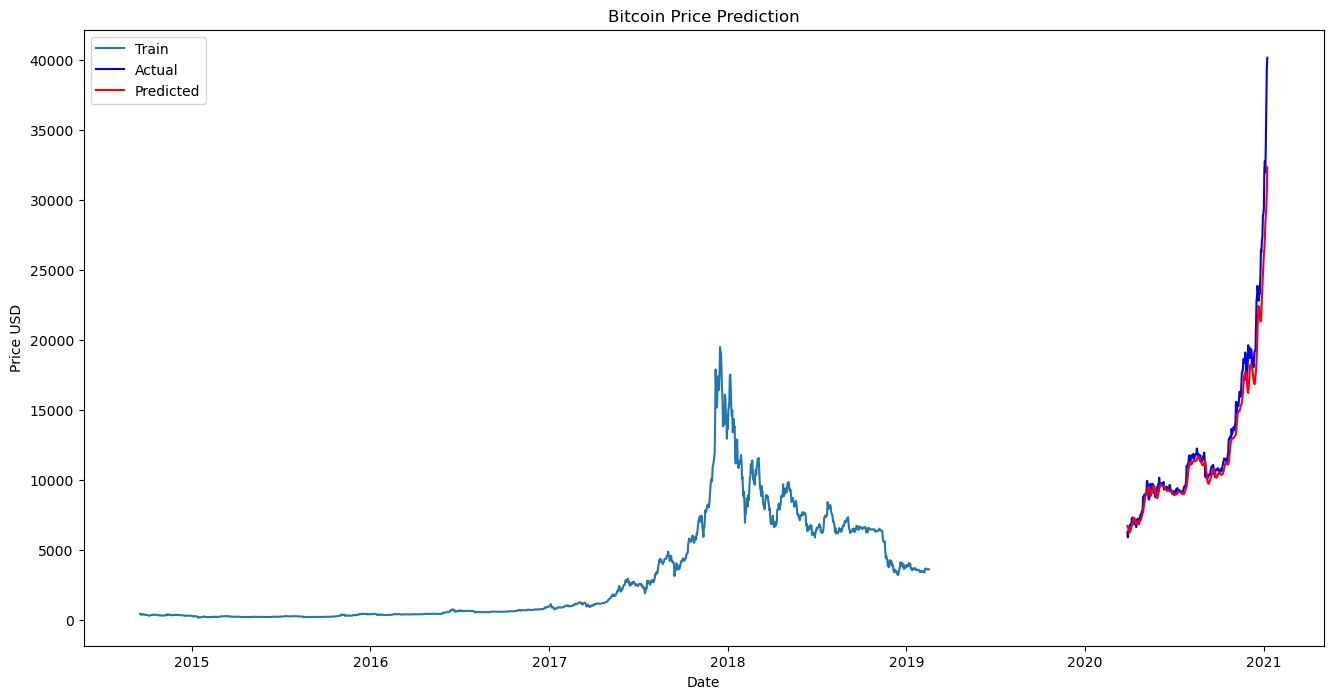

In [50]:
# Make predictions
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))

# Prepare DataFrames for plotting
train_data_df = df[:len(train_data)]
test_data_df = df[len(train_data) + len(val_data):]

# Adjust test_data_df to match length of test_predictions
test_data_df = test_data_df[-len(test_predictions):]
test_data_df['Predictions'] = test_predictions

# Plot training predictions vs actual
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.plot(train_data_df.index, train_data_df['Close'], label='Train')
plt.plot(test_data_df.index, test_data_df['Close'], color='blue', label='Actual')
plt.plot(test_data_df.index, test_data_df['Predictions'], color='red', label='Predicted')
plt.legend(['Train', 'Actual', 'Predicted'])
plt.show()

In [53]:
from tensorflow.keras.models import save_model, load_model

# Save the model
save_model(model, 'trained_model.h5')

# Load the model
loaded_model = load_model('trained_model.h5')
